# LightGlue Demo
In this notebook we match two pairs of images using LightGlue with early stopping and point pruning.

In [13]:
import sys
sys.path.insert(0,'/home/rmqlife/work/LightGlue')

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch



torch.set_grad_enabled(False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint", filter_threshold=0.9).eval().to(device)

## Easy example
The top image shows the matches, while the bottom image shows the point pruning across layers. In this case, LightGlue prunes a few points with occlusions, but is able to stop the context aggregation after 4/9 layers.

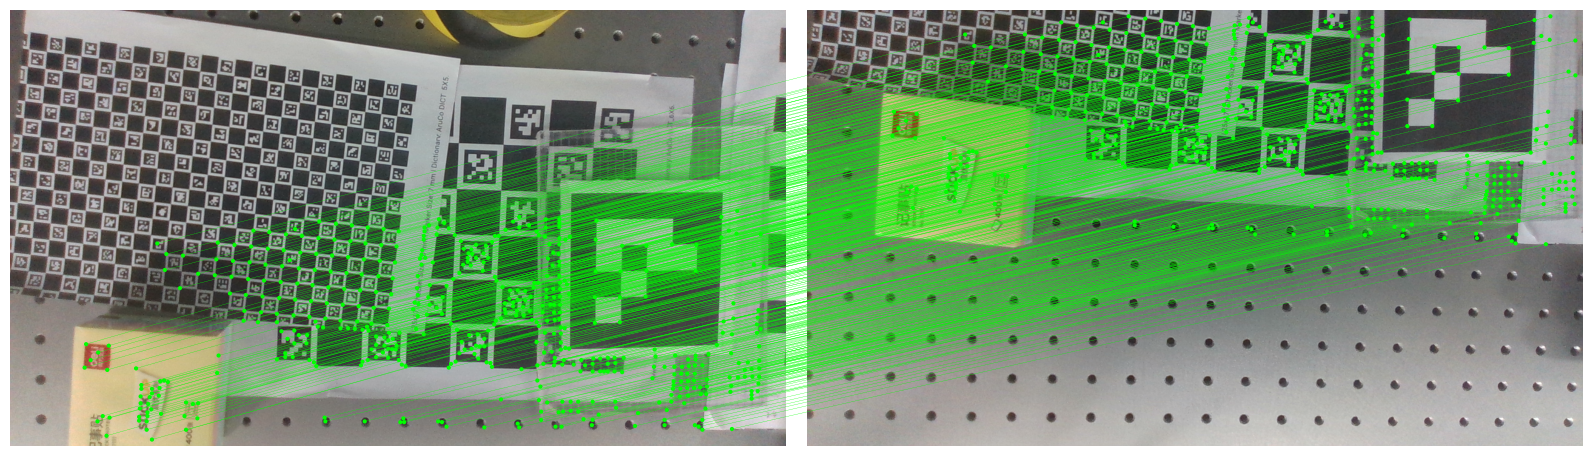

torch.Size([500, 2])
{'fx': 912.2659912109375, 'fy': 911.6720581054688, 's': 0.0, 'cx': 637.773193359375, 'cy': 375.817138671875}
(720, 1280)
x:0.21878544008035022 	 y:-0.017451543114722762 	 z:0.355
x:0.07758634324432782 	 y:-0.013366646950307745 	 z:0.35
x:0.20827863604255317 	 y:-0.013557599049597857 	 z:0.355
x:0.026331905536027468 	 y:-0.011729598405552448 	 z:0.347
x:0.09435253529138399 	 y:-0.01186480991455017 	 z:0.351
x:0.10231986022742615 	 y:-0.011763401282801879 	 z:0.348
x:0.12631116739457077 	 y:-0.011063187080797237 	 z:0.35
x:-0.047480792845661 	 y:-0.010343642679322628 	 z:0.339
x:0.07374974291753704 	 y:-0.010679277102545483 	 z:0.35
x:0.02975524919904679 	 y:-0.0094458824777806 	 z:0.347
x:0.10261388281428656 	 y:-0.009500325604453687 	 z:0.349
x:-0.03755799961007766 	 y:-0.008882390412694525 	 z:0.34
x:-0.02803177184645624 	 y:-0.007809235088959609 	 z:0.342
x:0.020187615536572077 	 y:-0.007900571171871417 	 z:0.346
x:0.08396411777795648 	 y:-0.008014741275511177 	 

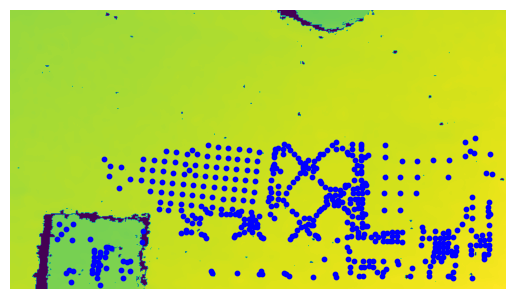

x:0.22541688224572787 	 y:-0.1400395901809185 	 z:0.349
x:0.0863106254640698 	 y:-0.13843455189804266 	 z:0.345
x:0.2154702218556423 	 y:-0.1377427116253209 	 z:0.349
x:0.034574968457637696 	 y:-0.13648050339981666 	 z:0.342
x:0.1029505091671224 	 y:-0.13729927524806962 	 z:0.345
x:0.11100139175781247 	 y:-0.1368795691992313 	 z:0.343
x:0.13431257534339328 	 y:-0.13575087386317114 	 z:0.343
x:-0.03932602257936706 	 y:-0.13482321576157197 	 z:0.336
x:0.08252883371337603 	 y:-0.13540714749811456 	 z:0.345
x:0.03682431242065904 	 y:-0.1334794242555401 	 z:0.342
x:0.11132501097576526 	 y:-0.13426000568393504 	 z:0.344
x:-0.029381554532325355 	 y:-0.13371755502420693 	 z:0.336
x:-0.019494934956966036 	 y:-0.13263692207887415 	 z:0.337
x:0.02895160855008435 	 y:-0.1323540195764364 	 z:0.342
x:0.09262920673551368 	 y:-0.13276345249847105 	 z:0.346
x:0.11164863019371807 	 y:-0.13200131754819544 	 z:0.345
x:-0.009919628093837743 	 y:-0.13117676669789818 	 z:0.338
x:0.02557759260555234 	 y:-0.13

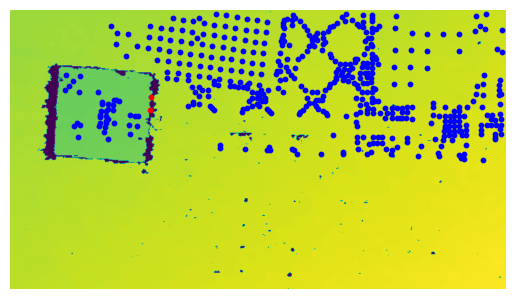

[(0.21878544008035022, -0.017451543114722762, 0.355), (0.07758634324432782, -0.013366646950307745, 0.35), (0.20827863604255317, -0.013557599049597857, 0.355), (0.026331905536027468, -0.011729598405552448, 0.347), (0.09435253529138399, -0.01186480991455017, 0.351), (0.10231986022742615, -0.011763401282801879, 0.348), (0.12631116739457077, -0.011063187080797237, 0.35), (-0.047480792845661, -0.010343642679322628, 0.339), (0.07374974291753704, -0.010679277102545483, 0.35), (0.02975524919904679, -0.0094458824777806, 0.347), (0.10261388281428656, -0.009500325604453687, 0.349), (-0.03755799961007766, -0.008882390412694525, 0.34), (-0.02803177184645624, -0.007809235088959609, 0.342), (0.020187615536572077, -0.007900571171871417, 0.346), (0.08396411777795648, -0.008014741275511177, 0.351), (0.10261388281428656, -0.007203447048856066, 0.349), (-0.017962091626932904, -0.0067033737736274124, 0.343), (0.01715341276384154, -0.006762003864941937, 0.346), (0.025571162499800956, -0.0067815472287134455,

In [16]:

import json
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import os

def replace_path(file_path, src, dst):
    directory, filename = os.path.split(file_path)  
    new_filename = filename.replace(src, dst)
    
    return os.path.join(directory, new_filename)
    
def replace_rgb_to_depth(file_path):
    return replace_path(file_path, 'rgb', 'depth')


# Factory function to create a pointcloud from an RGB-D image and a camera. Given depth value d at (u, v) image coordinate, the corresponding 3d point is:

# z = d / depth_scale
# x = (u - cx) * z / fx
# y = (v - cy) * z / fy
def project_to_3d(points, depth, intrinsics, show=True):
    if show:
        plt.imshow(depth)
    
    points_3d = list()
    
    for x,y in points:
        x = math.floor(x) 
        y = math.floor(y)
        d = depth[y][x]        
        # Plot points (x, y) on the image
        if show:
            if d>0:
                plt.scatter(x, y, color='blue', s=10)  # Adjust the size (s) as needed
            else:
                plt.scatter(x, y, color='red', s=10)

        # 3d point in meter
        z = d / 1000
        x = (x - intrinsics['cx']) * z / intrinsics['fx'] 
        y = (y - intrinsics['cy']) * z / intrinsics['fy'] 
        
        if show:
            print(f'x:{x} \t y:{y} \t z:{z}')
        points_3d.append((x,y,z))
        
    if show:
        plt.axis('off')  # Turn off axis labels
        plt.show()
    
    
    return points_3d
    
def load_intrinsics(json_file):
    with open(json_file, "r") as file:
        intrinsic_params = json.load(file)
    return intrinsic_params


def plot_matching(image0, image1, pts0, pts1):
    axes = viz2d.plot_images([image0, image1])
    viz2d.plot_matches(pts0, pts1, color="lime", lw=0.2)
    
def match_with_lightglue(image0, image1):
    feats0 = extractor.extract(image0.to(device))
    feats1 = extractor.extract(image1.to(device))
    matches01 = matcher({"image0": feats0, "image1": feats1})
    feats0, feats1, matches01 = [
        rbd(x) for x in [feats0, feats1, matches01]
    ]  # remove batch dimension

    kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
    m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]
    return m_kpts0, m_kpts1


id1=26
id2=19

image_path1 = f"images-20240611-194515/rgb_{id1}.png"
image_path2 = f"images-20240611-194515/rgb_{id2}.png"
traj_path = f"images-20240611-194515/traj.npy"

image0 = load_image(image_path1)
image1 = load_image(image_path2)

pts0, pts1 = match_with_lightglue(image0, image1)
plot_matching(image0, image1, pts0, pts1)
plt.show()
print(pts0.shape)

# Example usage:
intrinsics = load_intrinsics("intrinsic_parameters.json")
print(intrinsics)

depth_path1 = replace_rgb_to_depth(image_path1)
depth_path2 = replace_rgb_to_depth(image_path2)

rgb1 = cv2.imread(image_path1)
depth1 = cv2.imread(depth_path1, cv2.IMREAD_UNCHANGED)

rgb2 = cv2.imread(image_path2)
depth2 = cv2.imread(depth_path2, cv2.IMREAD_UNCHANGED)

print(depth2.shape)
image_size = depth2.shape

pt3d1 = project_to_3d(pts0[:], depth1, intrinsics)
pt3d2 = project_to_3d(pts1[:], depth2, intrinsics)

print(pt3d1)
print(pt3d2)


In [10]:

import cv2
import numpy as np
from lightglue_util import MyGlue, replace_rgb_to_depth, load_intrinsics, print_array
glue = MyGlue()

id1=26
id2=19

home = 'images-20240611-201439'

image_path1 = f"{home}/rgb_{id1}.png"
image_path2 = f"{home}/rgb_{id2}.png"
traj_path = f"{home}/traj.npy"
rgb1 = cv2.imread(image_path1)
rgb2 = cv2.imread(image_path2)

pts0, pts1 = glue.match_with_lightglue(rgb1, rgb2)

ModuleNotFoundError: No module named 'viz2d'

In [9]:
print(pts1[0])
pts0 = np.array(pts0)
pts1 = np.array(pts1)

# img_matches = cv2.drawMatches(rgb1, pts0, rgb2, pts1, None, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plot_matching(image0, image1, pts0, pts1)


[435  30]


NameError: name 'plot_matching' is not defined